In [7]:
import pickle
from pathlib import Path
from itertools import product

import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

from ds.wesad.datasets import subjects_data
from ds.wesad.datasets_users import SubjectsDataset, SubjectDataset
from conv_nets.wesad_tries.models_v2 import get_model

In [4]:
data_key = "rr_intervals"

epoch_count = 50
# signal_len = 60
ds_step_size = 5
test_batch_size = 1
device = "cuda"

In [5]:
def predict(model, dl):
    """Returns y_true, predicted classes and probabilities"""
    model.eval()
    y_true = []
    y_proba = []
    y_pred = []
    with torch.no_grad():
        for data in tqdm(dl):
            inputs, labels = data
            y_true.append(labels)
            inputs = inputs.to(torch.float32).to(device=device)

            outputs = model(inputs).cpu()
            y_proba.append(outputs[:, 1])
            y_pred.append(outputs.max(1).indices)
    return torch.cat(y_true), torch.cat(y_pred), torch.cat(y_proba)

In [6]:
def get_metrics(y_true, y_pred, _y_proba=None):
    return {
        "accuracy": metrics.accuracy_score(y_true, y_pred),
        "balanced_accuracy": metrics.balanced_accuracy_score(y_true, y_pred),
        "precision_score": metrics.precision_score(y_true, y_pred),
        "recall_score": metrics.recall_score(y_true, y_pred),
        "f1_score": metrics.f1_score(y_true, y_pred),
        "roc_auc_score": metrics.roc_auc_score(y_true, y_pred),
        # "confusion_matrix": metrics.confusion_matrix(y_true, y_pred),
        # precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_proba),
        # metrics.average_precision_score(y_true, y_pred),
        # fpr, tpr, thresholds_roc = metrics.roc_curve(y_true, y_proba),
    }

# Modifications

In [ ]:
def get_trained_model(
    base_path: Path,
    signal_len,
    reduce_type="max",
    numeric_derivative=False,
):
    Model = get_model(signal_len, reduce_type)
    net_with_optim_name = f"{Model.__name__}_ASGD_lr_1e-06"
    model = Model(numeric_derivative=numeric_derivative).to(device=device)
    net_out = base_path.joinpath(
        *[*(["derivative"] if numeric_derivative else []), net_with_optim_name]
    )
    best_path = next((net_out / net_with_optim_name).glob("*_best.pkl"))
    with open(best_path, "rb") as in_:
        pickled_data = pickle.load(in_)
    model.load_state_dict(pickled_data.get("net_state_dict"))
    return model

In [ ]:
all_dl = {}
for signal_len in (15, 30, 45, 60):
    ds = SubjectsDataset(
        subjects_data,
        ds_type="test",
        window_size=signal_len,
        step=ds_step_size,
        key=data_key,
        numeric_derivative=False,
    )
    ds_der = SubjectsDataset(
        subjects_data,
        ds_type="test",
        window_size=signal_len,
        step=ds_step_size,
        key=data_key,
        numeric_derivative=True,
    )
    dl = DataLoader(
        ds,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=1,
        pin_memory=False,
        drop_last=True,
    )
    dl_der = DataLoader(
        ds_der,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=1,
        pin_memory=False,
        drop_last=True,
    )
    all_dl.update({
        signal_len: {"dl": dl, "dl_der": dl_der}
    })

In [8]:
base_path = Path("steps")
nets_results = {}
for sig_len, r_type, num_der in tqdm(product(all_dl.keys(), ("conv", "avg", "max"), (True, False))):
    dl = all_dl.get(sig_len).get(f"dl{'_der' if num_der else ''}")
    model = get_trained_model(
        base_path, sig_len, reduce_type=r_type.lower(), numeric_derivative=num_der
    )
    y_true, y_pred, y_proba = predict(model, dl)
    nets_results[(sig_len, num_der, r_type)] = get_metrics(y_true, y_pred, y_proba)

0it [00:00, ?it/s]

  0%|          | 0/1443 [00:00<?, ?it/s]

  0%|          | 0/1443 [00:00<?, ?it/s]

  0%|          | 0/1443 [00:00<?, ?it/s]

  0%|          | 0/1443 [00:00<?, ?it/s]

  0%|          | 0/1443 [00:00<?, ?it/s]

  0%|          | 0/1443 [00:00<?, ?it/s]

  0%|          | 0/1427 [00:00<?, ?it/s]

  0%|          | 0/1427 [00:00<?, ?it/s]

  0%|          | 0/1427 [00:00<?, ?it/s]

  0%|          | 0/1427 [00:00<?, ?it/s]

  0%|          | 0/1427 [00:00<?, ?it/s]

  0%|          | 0/1427 [00:00<?, ?it/s]

  0%|          | 0/1407 [00:00<?, ?it/s]

  0%|          | 0/1407 [00:00<?, ?it/s]

  0%|          | 0/1407 [00:00<?, ?it/s]

  0%|          | 0/1407 [00:00<?, ?it/s]

  0%|          | 0/1407 [00:00<?, ?it/s]

  0%|          | 0/1407 [00:00<?, ?it/s]

  0%|          | 0/1390 [00:00<?, ?it/s]

  0%|          | 0/1390 [00:00<?, ?it/s]

  0%|          | 0/1390 [00:00<?, ?it/s]

  0%|          | 0/1390 [00:00<?, ?it/s]

  0%|          | 0/1390 [00:00<?, ?it/s]

  0%|          | 0/1390 [00:00<?, ?it/s]

In [31]:
nets_results = {(k[0], k[2], k[1]): v for k, v in nets_results.items()}

In [44]:
df = pd.DataFrame.from_dict(dict(sorted(nets_results.items()))).T

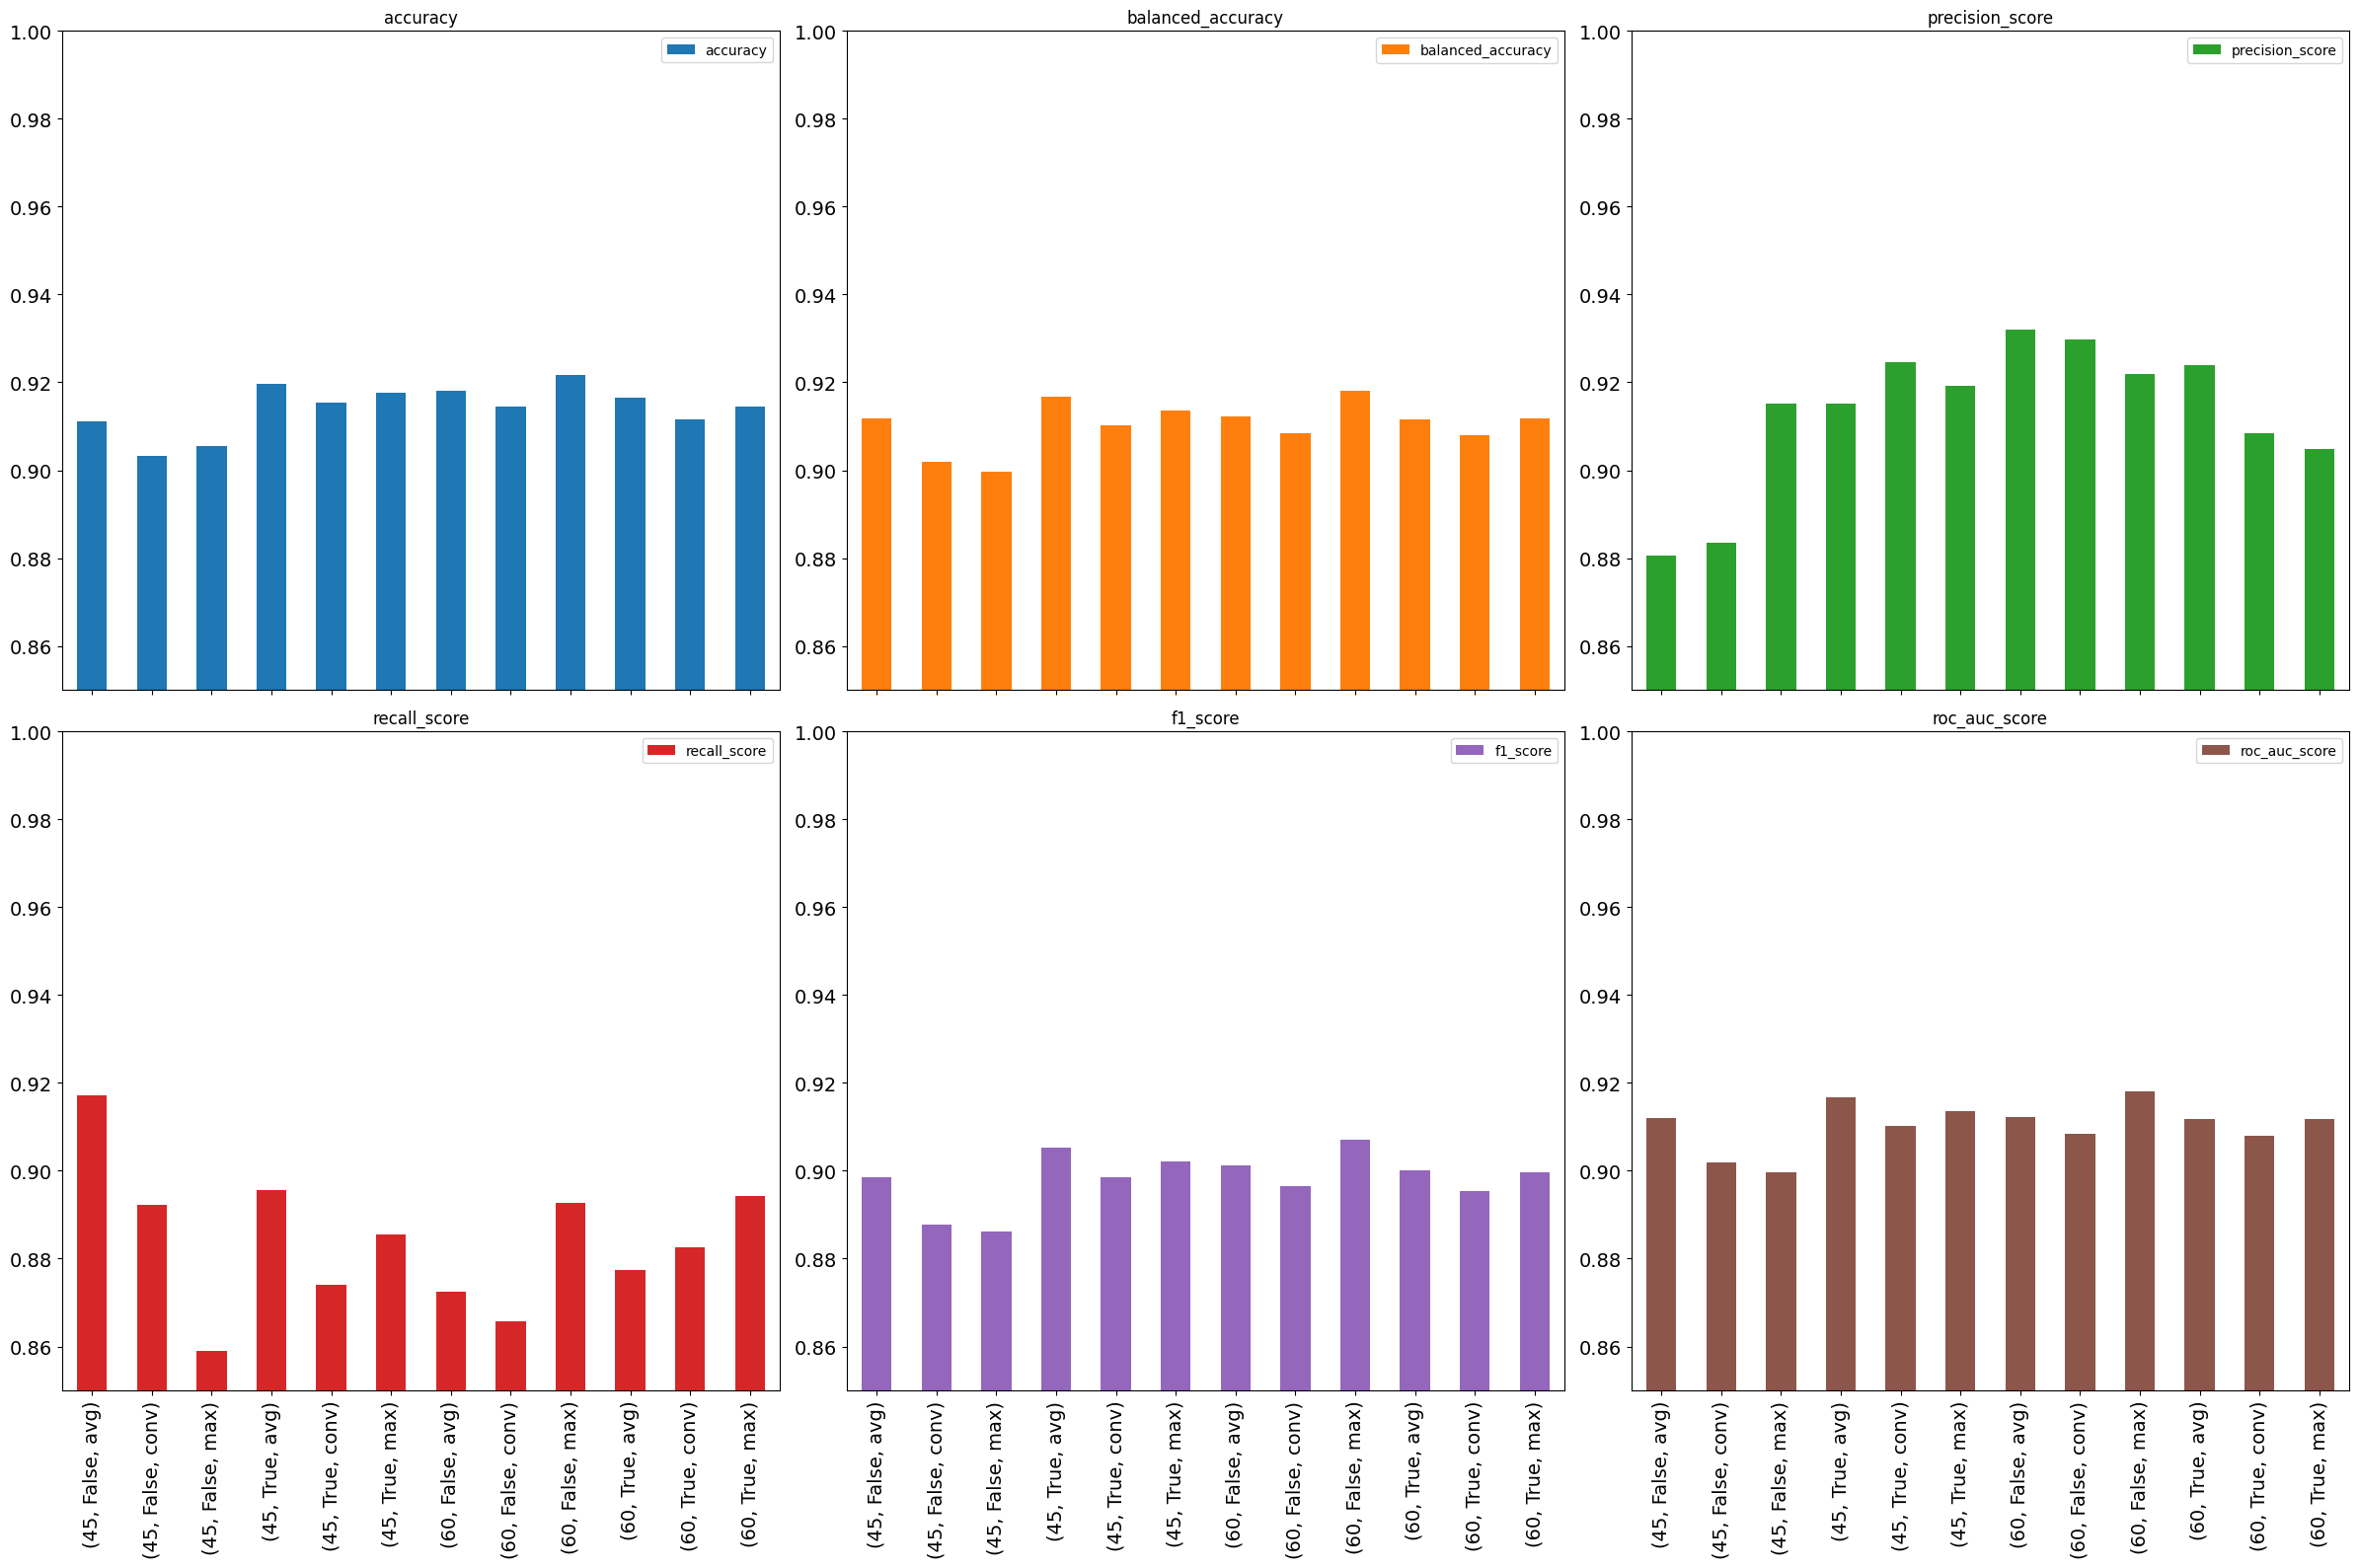

In [75]:
axes = df.loc[[45, 60]].plot.bar(
    subplots=True,
    layout=(2, 3),
    figsize=(24, 16),
    fontsize=14,
    ylim=(0.85, 1.0),
)
plt.tight_layout()

# Best skip users metrics

In [19]:
def get_personalised_trained_model(
    base_path: Path,
    signal_len: int,
    subject: int,
    reduce_type="max",
    numeric_derivative=False,
):
    Model = get_model(signal_len, reduce_type)
    net_with_optim_name = f"{Model.__name__}_ASGD_lr_1e-06"
    model = Model(numeric_derivative=numeric_derivative).to(device=device)
    net_out = base_path.joinpath(
        *[
            *(["derivative"] if numeric_derivative else []),
            "skip_users",
            net_with_optim_name
        ]
    )
    subj_net_path = (net_out / f"subj_{subject}_{net_with_optim_name}")
    best_path = next(subj_net_path.glob("*_best.pkl"))
    with open(best_path, "rb") as in_:
        pickled_data = pickle.load(in_)
    model.load_state_dict(pickled_data.get("net_state_dict"))
    return model

In [20]:
personalised_nets_results = {}
best_reduce_type = "avg"
best_num_der = True
for subj_id, subj_data in tqdm(subjects_data.items()):
    ds_subj = SubjectDataset(
        subj_data,
        step=ds_step_size,
        window_size=60,
        numeric_derivative=best_num_der,
        ds_type="test"
    )
    dl_subj = DataLoader(
        ds_subj,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=1,
        drop_last=True,
    )
    base_path = Path("subjects_related")
    model = get_personalised_trained_model(
        base_path,
        60,
        subj_id,
        reduce_type=best_reduce_type,
        numeric_derivative=best_num_der,
    )
    y_true, y_pred, y_proba = predict(model, dl_subj)
    personalised_nets_results[subj_id] = get_metrics(y_true, y_pred, y_proba)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

In [27]:
pd.DataFrame.from_dict(dict(sorted(personalised_nets_results.items()))).T.round(3).to_csv()

',accuracy,balanced_accuracy,precision_score,recall_score,f1_score,roc_auc_score\n2,0.955,0.932,1.0,0.864,0.927,0.932\n3,1.0,1.0,1.0,1.0,1.0,1.0\n4,1.0,1.0,1.0,1.0,1.0,1.0\n5,1.0,1.0,1.0,1.0,1.0,1.0\n6,1.0,1.0,1.0,1.0,1.0,1.0\n7,1.0,1.0,1.0,1.0,1.0,1.0\n8,1.0,1.0,1.0,1.0,1.0,1.0\n9,0.909,0.886,0.926,0.806,0.862,0.886\n10,0.967,0.958,1.0,0.917,0.957,0.958\n11,1.0,1.0,1.0,1.0,1.0,1.0\n13,1.0,1.0,1.0,1.0,1.0,1.0\n14,1.0,1.0,1.0,1.0,1.0,1.0\n15,1.0,1.0,1.0,1.0,1.0,1.0\n16,1.0,1.0,1.0,1.0,1.0,1.0\n17,1.0,1.0,1.0,1.0,1.0,1.0\n'

# Check metrics

In [ ]:
model = get_trained_model(base_path, 60)
dl = all_dl.get(60).get("dl")

In [ ]:
y_true, y_pred, y_proba = predict(model, dl)

In [ ]:
acc = metrics.accuracy_score(y_true, y_pred)
acc

In [ ]:
balanced_acc = metrics.balanced_accuracy_score(y_true, y_pred)
balanced_acc

In [ ]:
conf_matrix = metrics.confusion_matrix(y_true, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

In [ ]:
precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_proba)
disp = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

In [ ]:
metrics.average_precision_score(y_true, y_pred)

In [ ]:
metrics.precision_score(y_true, y_pred)

In [ ]:
metrics.recall_score(y_true, y_pred)

In [ ]:
metrics.f1_score(y_true, y_pred)

In [ ]:
metrics.fbeta_score(y_true, y_pred, beta=2)

In [ ]:
roc_auc_score = metrics.roc_auc_score(y_true, y_pred)
roc_auc_score

In [ ]:
fpr, tpr, thresholds_roc = metrics.roc_curve(y_true, y_proba)

In [ ]:
disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_score)
disp.plot()
plt.show()